# Examples

In [10]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from dynopt.models.models import Model

## Example 1. Linear Regression with Boston Housing Data

In [14]:
# Load dataset
data = fetch_california_housing()
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [15]:
data.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [16]:
# Define data names
feature_names = data.feature_names
target_name = 'MedHouseVal'  # Median value of homes in $1000s

# Construct Pandas dataframes
X = pd.DataFrame(data.data, columns=feature_names)
y = pd.DataFrame(data.target, columns=[target_name])

print(X.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  


In [17]:
print(y.head())

   MedHouseVal
0        4.526
1        3.585
2        3.521
3        3.413
4        3.422


In [20]:
# Select desired inputs and outputs
x_names = ['MedInc', 'HouseAge', 'AveRooms']
y_names = [target_name]

# Initialize model
model = Model(x_names, y_names)  # by default uses a linear estimator

print(model)

Model(['MedInc', 'HouseAge', 'AveRooms'], ['MedHouseVal'], estimator=LinearRegression())


In [21]:
# Fit model
model.fit(X, y)

# Fit score (R-squared)
print(model.score(X, y))

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- x0
- x1
- x2
Feature names seen at fit time, yet now missing:
- AveRooms
- HouseAge
- MedInc


In [22]:
# Prediction with fitted model

print(model.predict(X.head()))

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- x0
- x1
- x2
Feature names seen at fit time, yet now missing:
- AveRooms
- HouseAge
- MedInc


In [ ]:
# Single point prediction is also supported
x = {'LSTAT': 4.98, 'RM': 6.575, 'TAX': 296}
print(model.predict(x))

{'MEDV': 29.01211141973685}


## Simple Pendulum Example

In [23]:
import numpy as np

def pendulum_dydt(t, y):
    dydt = np.empty_like(y)
    dydt[0] = y[1]
    dydt[1] = -y[1] - 5*np.sin(y[0])
    return dydt

In [24]:
from scipy.integrate import odeint

# Integrate dy/dt over time
t = np.arange(0, 10, 0.1)
y0 = [0.1, 0]  # Initial condition
y = odeint(pendulum_dydt, y0, t, tfirst=True)
assert y.shape == (100, 2), y.shape

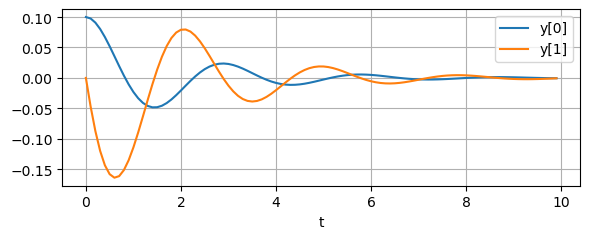

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,2.5))
for i in range(y.shape[1]):
    plt.plot(t, y[:,i], label=f'y[{i}]')
plt.xlabel('t')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('images/pendulum-time-plot.png')
plt.show()

In [26]:
# Calculate dydt values
dydt = pendulum_dydt(t, y.T).T
assert dydt.shape == (100, 2)

In [27]:
from dynopt.models.models import NonLinearModel

# Labels for inputs and outputs
x_names = ['theta', 'theta_dot']
y_names = ['theta_dot', 'theta_ddot']

# Choose input features including non-linear terms
x_features = ['x1', 'sin(x0)']

# Initialize model
model = NonLinearModel(x_names, y_names, x_features=x_features)

In [28]:
# Prepare pandas dataframes for inputs and outputs
y = pd.DataFrame(y, columns=x_names)
dydt = pd.DataFrame(dydt, columns=y_names)
print(y.head())

      theta  theta_dot
0  0.100000   0.000000
1  0.097595  -0.047109
2  0.090802  -0.087513
3  0.080359  -0.119943
4  0.067106  -0.143621


In [29]:
print(dydt.head())

   theta_dot  theta_ddot
0   0.000000   -0.499167
1  -0.047109   -0.440093
2  -0.087513   -0.365874
3  -0.119943   -0.281420
4  -0.143621   -0.191657


In [30]:
# Fit the linear model
model.fit(y, dydt)
print(model.coef_.round(5))

     x1  sin(x0)
y0  1.0     -0.0
y1 -1.0     -5.0


In [31]:
print(model.intercept_.round(5))

y0   -0.0
y1    0.0
dtype: float64


In [32]:
from dynopt.models.models import SparseNonLinearModel

# Labels for inputs and outputs
x_names = ['theta', 'theta_dot']
y_names = ['theta_dot', 'theta_ddot']

# Choose additional non-linear features for model identification
custom_features = ['sin(x0)', 'cos(x0)', 'sin(x0)**2', 
                   'cos(x0)**2', 'sin(x0)*cos(x0)']

# Initialize SINDy model
model = SparseNonLinearModel(x_names, y_names, 
                             custom_features=custom_features,
                             poly_order=2)

In [33]:
# Prepare pandas dataframes for inputs and outputs
y = pd.DataFrame(y, columns=x_names)
dydt = pd.DataFrame(dydt, columns=y_names)

In [34]:
# Sparse identification of non-linear dynamics (SINDy)
threshold = 0.2  # Sparsity parameter
model.fit(y, dydt, threshold=threshold)
print(model.n_params)

3


In [35]:
print(model.coef_)

     x1  sin(x0)
y0  1.0      0.0
y1 -1.0     -5.0
